In [1]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm
import logging
import seaborn as sn

from rsna_dataloader import *


In [2]:
class CustomResNet(nn.Module):
    def __init__(self, out_features=512, pretrained_weights=None):
        super(CustomResNet, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features=num_ftrs, out_features=out_features)

    def forward(self, x):
        return self.model(x)


class CustomLSTM(nn.Module):
    hidden_size = 256
    num_layers = 2

    def __init__(self, num_classes=5 * 2, drop_rate=0.2, resnet_weights=None):
        super(CustomLSTM, self).__init__()
        self.cnn = CustomResNet(pretrained_weights=resnet_weights)
        self.lstm = nn.LSTM(input_size=512, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            # nn.BatchNorm1d(256),
            nn.Dropout(drop_rate),
            nn.LeakyReLU(0.1),
            nn.Linear(128, num_classes),
        )
    def forward(self, x_3d):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            x = self.cnn(x_3d[:, t])
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

            # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.head(hidden[0][-1])

        return x


In [3]:
model = torch.load("../models/resnet18_lstm_t2stir.pt")

In [4]:
transform_val = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [2]:
data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

In [6]:
test_loader = create_series_level_test_datasets_and_loaders(training_data, "Sagittal T2/STIR", transform_val, data_basepath + "train_images")

In [7]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
def get_output_class(val):
    if val <= 0.33:
        return 0
    elif val <= 0.66:
        return 1
    else:
        return 2

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomLSTM(
  (cnn): CustomResNet(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [9]:
preds = []
for image, label in tqdm(test_loader):
    image = image.to(device)
    preds.append((model(image).detach().cpu().numpy(), label.numpy()))
    if len(preds) == 100:
        break

  5%|▌         | 99/1973 [00:32<10:17,  3.03it/s]


In [10]:
preds

[(array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193  , -531.88324 ,  -34.887356]],
        dtype=float32),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])),
 (array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193  , -531.88324 ,  -34.887356]],
        dtype=float32),
  array([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0]])),
 (array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193  , -531.88324 ,  -34.887356]],
        dtype=float32),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])),
 (array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193  , -531.88324 ,  -34.887356]],
        dtype=float32),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])),
 (array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193

In [11]:
def scores_to_classes(arr):
    ret = []
    for i in range(0, len(arr)-1, 2):
        if arr[i] == 0:
            ret.append(0)
        elif arr[i] == 1:
            ret.append(2)
        else:
            ret.append(1)
            
    return ret

In [12]:
pred_classes = [(scores_to_classes(e[0][0]), scores_to_classes(e[1][0])) for e in preds]

In [13]:
pred_classes_0 = [e[0][4] for e in pred_classes]
pred_classes_0_ = [e[1][4] for e in pred_classes]

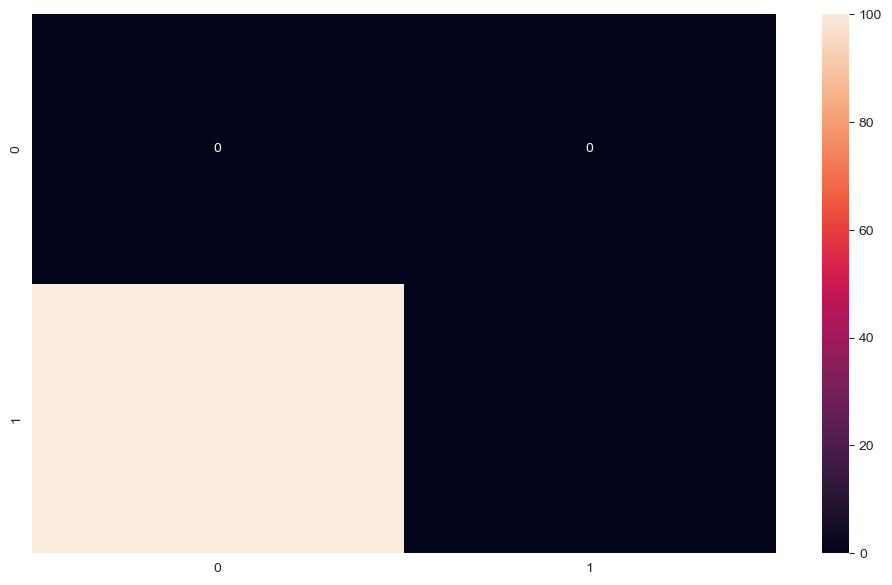

In [14]:
cf_matrix = confusion_matrix(pred_classes_0, pred_classes_0_)
df_cm = pd.DataFrame(cf_matrix)
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
plt.show()


In [15]:
training_data

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,../data/rsna-2024-lumbar-spine-degenerative-cl...
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,../data/rsna-2024-lumbar-spine-degenerative-cl...
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,../data/rsna-2024-lumbar-spine-degenerative-cl...
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,../data/rsna-2024-lumbar-spine-degenerative-cl...
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,../data/rsna-2024-lumbar-spine-degenerative-cl...
...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,normal_mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_right_subarticular_stenosis_l1_l2,../data/rsna-2024-lumbar-spine-degenerative-cl...
48688,4290709089,Right Subarticular Stenosis,L2/L3,normal_mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_right_subarticular_stenosis_l2_l3,../data/rsna-2024-lumbar-spine-degenerative-cl...
48689,4290709089,Right Subarticular Stenosis,L3/L4,normal_mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_right_subarticular_stenosis_l3_l4,../data/rsna-2024-lumbar-spine-degenerative-cl...
48690,4290709089,Right Subarticular Stenosis,L4/L5,normal_mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_right_subarticular_stenosis_l4_l5,../data/rsna-2024-lumbar-spine-degenerative-cl...


In [16]:
training_data[training_data["condition"] == "Spinal Canal Stenosis"].groupby(["severity"]).count()

,study_id,condition,level,series_id,instance_number,x,y,series_description,row_id,image_path
severity,,,,,,,,,,
moderate,732,732,732,732,732,732,732,732,732,732
normal_mild,8552,8552,8552,8552,8552,8552,8552,8552,8552,8552
severe,469,469,469,469,469,469,469,469,469,469


In [27]:
pretrained_coord_path = "C:\\Users\Victor\\Documents\\python-doodles\\models\\resnet34_cnn_coordinates_t2stir\\resnet34_cnn_coordinates_t2stir_15.pt"

In [28]:
import torch.nn as nn
from transformers import AutoModelForImageClassification

class CoordinateDetector2D(nn.Module):
    def __init__(self, out_features=10, pretrained_weights=None):
        super(CoordinateDetector2D, self).__init__()
        self.model = AutoModelForImageClassification.from_pretrained("BehradG/resnet-18-MRI-Brain", torchscript=True)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=out_features),
        )

    def forward(self, x):
        return self.model(x)[0]


In [29]:
import torch

coordinate_model = torch.load(pretrained_coord_path)

In [30]:
from rsna_dataloader import *

In [323]:
from torchvision import transforms
from torchvision.transforms import v2

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

transform_train = TrainingTransform()

transform_val = ValidationTransform()

KeyboardInterrupt: 

In [15]:
trainloader, valloader, trainset, valset = create_coordinate_datasets_and_loaders(training_data,
                                                                                 "Sagittal T2/STIR",
                                                                                 transform_train,
                                                                                 transform_val,
                                                                                 data_basepath + "train_images",
                                                                                 num_workers=0,
                                                                                 batch_size=1)


NameError: name 'create_coordinate_datasets_and_loaders' is not defined

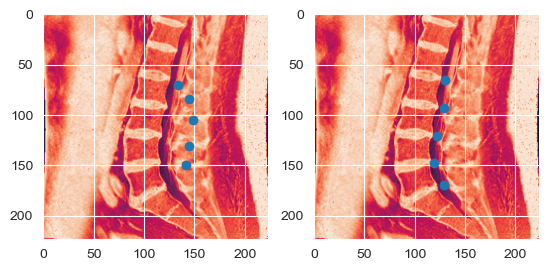

In [34]:
def show_inference_vs_label_for_index(index: int):
    image, label = trainset[index]
    f, axarr = plt.subplots(1, 2)
    
    inferred = coordinate_model(image.unsqueeze(0).to("cuda")).detach().cpu()
    x_ = [inferred[i] for i in range(0, len(inferred), 2)]
    y_ = [inferred[i] for i in range(1, len(inferred), 2)]
    
    axarr[0].scatter(x_, y_) 
    axarr[0].imshow(image.squeeze(0)[0])
    
    x = [label[i] for i in range(0, len(label), 2)]
    y = [label[i] for i in range(1, len(label), 2)]
    
    plt.scatter(x, y)
    axarr[1].imshow(image.squeeze(0)[0])

show_inference_vs_label_for_index(15)

In [9]:
from torchvision.ops import distance_box_iou_loss, generalized_box_iou_loss, complete_box_iou_loss

class DistanceBoxIOULoss(nn.Module):
    def forward(self, inferred, target):
        inferred_boxes = get_bounding_boxes_for_label(inferred).reshape(-1, 4)
        target_boxes = get_bounding_boxes_for_label(target).reshape(-1, 4)

        return complete_box_iou_loss(inferred_boxes, target_boxes, reduction='mean')


In [22]:
loss = DistanceBoxIOULoss()

In [23]:
from tqdm import tqdm

losses = []
for i, val in tqdm(enumerate(valset)):
    try:
        image, label = val
        inferred = coordinate_model(image.unsqueeze(0).to("cuda")).detach().cpu()
        losses.append((loss(inferred, label), i))
    except Exception as e:
        continue

0it [14:38, ?it/s]


KeyboardInterrupt: 

In [177]:
sorted_losses = sorted(losses, key=lambda x: x[0], reverse=True)
sorted_losses[:10]

[(tensor(1.7479), 1330),
 (tensor(1.7479), 1331),
 (tensor(1.7479), 1332),
 (tensor(1.7479), 1333),
 (tensor(1.7479), 1334),
 (tensor(1.7376), 440),
 (tensor(1.7376), 441),
 (tensor(1.7376), 442),
 (tensor(1.7376), 443),
 (tensor(1.7376), 444)]

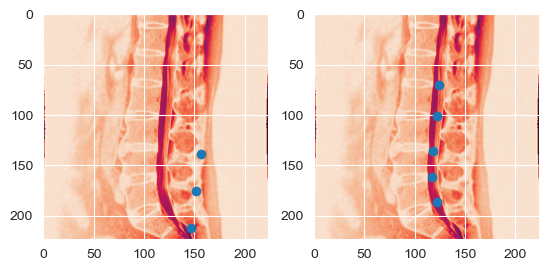

In [179]:
show_inference_vs_label_for_index(1330)

In [1]:
import torch
import torch.nn as nn

loss = nn.BCELoss()

In [2]:
logit = torch.tensor([[0.0,1.0,1.0], [0.0,1.0,0.0]])
target = torch.tensor([[1.0,1.0,0.0], [0.0,1.0,1.0]])
loss(logit, target)

tensor(50.)

In [322]:
from rsna_dataloader import *

trainloader, valloader, trainset, valset = create_datasets_and_loaders(training_data,
                                                                         "Sagittal T2/STIR",
                                                                         transform_train,
                                                                         transform_val,
                                                                         num_workers=0,
                                                                         split_factor=0.1,
                                                                         batch_size=1)


C:\Users\Victor\anaconda3\envs\python-doodles\Lib\site-packages\torch\utils\data\sampler.py:227: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights_tensor = torch.as_tensor(weights, dtype=torch.double)


In [274]:
trainset.dataframe.describe()

,study_id,series_id,instance_number,x,y
count,9.748000e+03,9.748000e+03,9748.000000,9748.000000,9748.000000
mean,2.159352e+09,2.187963e+09,9.013131,255.056065,246.415846
std,1.236708e+09,1.248598e+09,1.574663,78.640085,110.770014
min,4.003253e+06,3.701090e+05,1.000000,4.058824,2.063098
25%,1.093392e+09,1.095129e+09,8.000000,196.361852,164.241922
50%,2.192458e+09,2.191396e+09,9.000000,244.082251,227.270218
75%,3.220086e+09,3.265080e+09,10.000000,292.274368,313.086277
max,4.290709e+09,4.294540e+09,20.000000,686.102602,801.859719


In [275]:
valset.dataframe.describe()

,study_id,series_id,instance_number,x,y
count,3.981000e+03,3.981000e+03,3981.000000,3981.000000,3981.000000
mean,2.138333e+09,2.207361e+09,9.056267,255.203961,246.699768
std,1.251080e+09,1.273349e+09,1.534642,80.167950,111.453344
min,4.003253e+06,1.886355e+07,4.000000,4.999978,2.063098
25%,1.028684e+09,1.095129e+09,8.000000,196.173913,163.649123
50%,2.179594e+09,2.212768e+09,9.000000,242.247382,227.128492
75%,3.215006e+09,3.342733e+09,10.000000,293.782114,313.094765
max,4.287160e+09,4.294540e+09,15.000000,686.102602,766.004849


In [5]:
import timm
import torch.nn as nn
import torch

class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            num_classes=CONFIG["out_dim"],
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CONFIG["drop_rate"], bidirectional=True, batch_first=True)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.Dropout(CONFIG["drop_rate_last"]),
                nn.LeakyReLU(0.1),
                nn.Linear(256, CONFIG["out_dim"]),
                nn.Softmax(),
            )
            for i in range(CONFIG["n_levels"])])

    def forward(self, x):
        feat = self.encoder(x)
        feat, _ = self.lstm(feat)
        return torch.stack([head(feat) for head in self.heads], dim=1)


In [348]:
inference_model = torch.load("C:\\Users\Victor\\Documents\\python-doodles\\models\\efficientnetv2_b3_lstm_t2stir\\efficientnetv2_b3_lstm_t2stir_99.pt")

In [349]:
inferred = []
target = []
for image, label in valloader:
    target.append(label.detach())
    inferred.append(inference_model(image.to("cuda")).detach())

C:\Users\Victor\anaconda3\envs\python-doodles\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [350]:
inferred = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in inferred]

In [351]:
target = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in target]

In [352]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

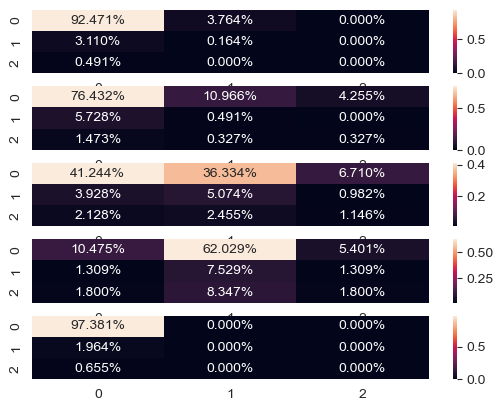

In [347]:
fig, ax = plt.subplots(nrows=5)
for i in range(5):
    target_ = [e[i] for e in target]
    inferred_ = [e[i] for e in inferred]
    
    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix/np.sum(cf_matrix), ax=ax[i], annot=True, fmt='.3%')

plt.show()

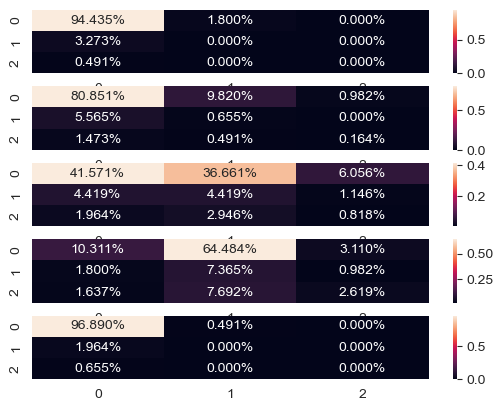

In [353]:
fig, ax = plt.subplots(nrows=5)
for i in range(5):
    target_ = [e[i] for e in target]
    inferred_ = [e[i] for e in inferred]

    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix / np.sum(cf_matrix), ax=ax[i], annot=True, fmt='.3%')

plt.show()


In [142]:
(training_data[["severity", "level"]].value_counts() / training_data[["level"]].value_counts()).groupby(["level","severity"]).mean().head(20)

level  severity   
L1/L2  moderate       0.041605
       normal_mild    0.948363
       severe         0.009293
L2/L3  moderate       0.101853
       normal_mild    0.874237
       severe         0.023186
L3/L4  moderate       0.199026
       normal_mild    0.740414
       severe         0.059850
L4/L5  moderate       0.277845
       normal_mild    0.574863
       severe         0.146581
L5/S1  moderate       0.190046
       normal_mild    0.734688
       severe         0.074556
Name: count, dtype: float64

In [118]:
(valset.dataframe[["severity", "level"]].value_counts() / valset.dataframe[["level"]].value_counts())


severity     level
normal_mild  L1/L2    0.953125
moderate     L1/L2    0.036719
severe       L1/L2    0.010156
normal_mild  L2/L3    0.893159
moderate     L2/L3    0.079170
severe       L2/L3    0.027671
normal_mild  L3/L4    0.816805
moderate     L3/L4    0.117335
severe       L3/L4    0.065859
normal_mild  L4/L5    0.743182
severe       L4/L5    0.135606
moderate     L4/L5    0.121212
normal_mild  L5/S1    0.966616
moderate     L5/S1    0.024279
severe       L5/S1    0.009105
Name: count, dtype: float64

In [315]:
training_data["series_description"]

0        Sagittal T2/STIR
1        Sagittal T2/STIR
2        Sagittal T2/STIR
3        Sagittal T2/STIR
4        Sagittal T2/STIR
5             Sagittal T1
6             Sagittal T1
               ...       
48685            Axial T2
48686            Axial T2
48687            Axial T2
48688            Axial T2
48689            Axial T2
48690            Axial T2
48691            Axial T2
Name: series_description, Length: 48692, dtype: object

In [317]:
model_scripted = torch.jit.script(inference_model)# Export to TorchScript

model_scripted.save('efficientnetv2_b3_lstm_t2stir_109.pt') # Save

In [321]:
training_data.columns

Index(['study_id', 'condition', 'level', 'severity', 'series_id',
       'instance_number', 'x', 'y', 'series_description', 'row_id',
       'image_path'],
      dtype='object')